In [61]:
from __future__ import print_function, division
import os

from IPython import display
import sys
import importlib
import time
from tqdm import tqdm


import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import math

import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic

import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import colors

rcParams.update({'figure.autolayout': True})
#plt.rc('font', family='serif')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
mpl.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = "serif"
#plt.rcParams['font.serif'] = "cm"
#plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"

/tmp/ipykernel_1696/818240295.py:34: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'png')


In [70]:
def king_(x,s,g):
    '''
    King profile (see Eq (3) 1309.5416)
    
    NOTE: This is a function of the angular deviation (radial distance).
    Therefore, the distribution is given by the expression in Eq (3) in 1309.5416
    multiplied by a factor of 2 \pi x, as we integrate over the azimuthal angles.

    Parameters
    ----------
    x : float
        angular deviation from the center
    s : float
        sigma parameter
    g : float
        gamma parameter

    Returns
    -------
    float
        King profile

    '''
    return x * (1 - 1 / g) * (1 + (x*x / 2 / s/s / g))**(-g) / s / s

def king2_(x,s1,g1,s2,g2,f):
    '''
    Double King profile

    Parameters
    ----------
    x : float
        angular deviation from center
    s1 : float
        core sigma parameter
    g1 : float
        core gamma parameter
    s2 : float
        tail sigma parameter
    g2 : float
        tail gamma parameter
    f : float
        fraction of the tail king profile

    Returns
    -------
    float
        Double King profile
    '''
    return f * king_(x,s1,g1) + (1 - f) * king_(x,s2,g2)

def king_inv_cdf_(F,s,g):
    """
    Inverse cdf of King profile

    Parameters
    ----------
    F : float
        cdf
    s : float
        sigma parameter
    g : float
        gamma parameter
        
    Returns
    -------
    float
        inverse cdf
    """
    return (2 * g * s**2. * ( (1 - F)**(- 1 / (g - 1) ) - 1. ))**(0.5)

def generate_samples_king_(N,s,g):
    """
    Generate samples from King profile
    using inverse transform technique
    
    Parameters
    ----------
    N : int
        number of samples
    s : float
        sigma parameter
    g : float   
        gamma parameter

    Returns
    ------- 
    array
        samples from King profile    
    """
    uniform_samples = np.random.uniform(0,1,N)
    return king_inv_cdf_(uniform_samples,s,g)

def generate_samples_king2_(N,s1,g1,s2,g2,f):
    """
    Generate samples from Double King profile
    using inverse transform technique

    Parameters
    ----------
    N : int
        number of samples
    s1 : float
        core sigma parameter
    g1 : float  
        core gamma parameter
    s2 : float
        tail sigma parameter
    g2 : float
        tail gamma parameter
    f : float
        fraction of the tail king profile

    Returns
    ------- 
    array
        samples from Double King profile
    """
    king2_samples = np.empty(N)

    uniform_samples_1 = np.random.uniform(0,1,N)
    king_rvs_1 = king_inv_cdf_(uniform_samples_1,s1,g1)

    uniform_samples_2 = np.random.uniform(0,1,N)
    king_rvs_2 = king_inv_cdf_(uniform_samples_2,s2,g2)

    arr_bool = (np.random.uniform(low = 0, high = 1, size = N) <= f)
    king2_samples[arr_bool] = king_rvs_1[arr_bool]
    king2_samples[~arr_bool] = king_rvs_2[~arr_bool]

    return king2_samples

def interpolate_king_parameters_():
    """
    Interpolate empirically fit 
    double-King profile parameters as a function of energy
    
    Parameters
    ----------
    None

    Returns
    ------- 
    function
        interpolation of score vs logE
    function
        interpolation of gcore vs logE
    function
        interpolation of stail vs logE
    function
        interpolation of gtail vs logE
    function
        interpolation of fcore vs logE
    """
    
    # load zhong's psf fit data
    params_dir = 'zhong_psf_params/'

    arr_E = np.loadtxt(params_dir + 'CLEAN_FRONT_gcore_vs_E.dat')[:,0]
    arr_logE = np.log10(arr_E)

    arr_score = np.loadtxt(params_dir + 'CLEAN_FRONT_score_vs_E.dat')[:,1]
    arr_stail = np.loadtxt(params_dir + 'CLEAN_FRONT_stail_vs_E.dat')[:,1]
    arr_gcore = np.loadtxt(params_dir + 'CLEAN_FRONT_gcore_vs_E.dat')[:,1]
    arr_gtail = np.loadtxt(params_dir + 'CLEAN_FRONT_gtail_vs_E.dat')[:,1]
    arr_Ntail = np.loadtxt(params_dir + 'CLEAN_FRONT_Ntail_vs_E.dat')[:,1]
    arr_fcore = 1 - arr_Ntail # fraction of core (notation consistent with reference)

    f_E_score = interp1d(arr_logE, arr_score, kind='cubic',assume_sorted=True)
    f_E_stail = interp1d(arr_logE, arr_stail, kind='cubic')
    f_E_gcore = interp1d(arr_logE, arr_gcore, kind='cubic')
    f_E_gtail = interp1d(arr_logE, arr_gtail, kind='cubic')
    f_E_fcore = interp1d(arr_logE, arr_fcore, kind='cubic')

    return [f_E_score, f_E_gcore, f_E_stail,  f_E_gtail, f_E_fcore]

# define the psf in terms of the interpolated data

def psf_(x, E, interpolation_functions):
    '''
    Double King profile over interpolated fit parameters

    Parameters
    ----------
    x : float
        angular deviation from center (deg)
    E : float
        energy (MeV)
    interpolation_functions : list
        list of interpolation functions determined by "interpolate_king_parameters_()"

    Returns
    -------
    float
        Double King profile
    '''
    
    logE = np.log10(E)
    f_E_score, f_E_gcore, f_E_stail,  f_E_gtail, f_E_fcore = interpolation_functions
    return king2_(x, f_E_score(logE), f_E_gcore(logE), f_E_stail(logE), f_E_gtail(logE), f_E_fcore(logE))

def generate_samples_psf_(N, E, interpolation_functions):
    """
    Generate samples from PSF
    using inverse transform technique

    Parameters
    ----------
    N : int
        number of samples
    E : float
        energy
    interpolation_functions : list
        list of interpolation functions determined by "interpolate_king_parameters_()"

    Returns
    ------- 
    array
        samples from PSF
    """
    logE = np.log10(E)
    f_E_score, f_E_gcore, f_E_stail,  f_E_gtail, f_E_fcore = interpolation_functions
    
    s1 = f_E_score(logE)
    g1 = f_E_gcore(logE)
    s2 = f_E_stail(logE)
    g2 = f_E_gtail(logE)
    f = f_E_fcore(logE)
    return generate_samples_king2_(N,s1,g1,s2,g2,f)


In [71]:
# print current directory

print(os.getcwd())

/mnt/c/Users/Edwar/OneDrive - Rutgers University/projects/pswavelets/gce/matt_post_energy


In [72]:
# create interpolated parameters
interpolation_functions = interpolate_king_parameters_()
E = 1000 # energy in MeV
inv_rvs = generate_samples_psf_(1000000, E, interpolation_functions)


Text(0, 0.5, '$p(x)$')

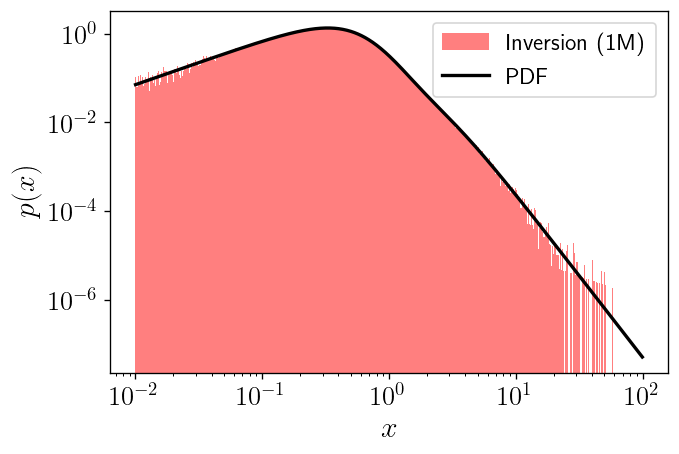

In [73]:
fig = plt.figure(figsize=(6, 4), dpi= 120)
ax = fig.add_subplot(111)

_, bins, _ = ax.hist(inv_rvs, bins = np.logspace(-2,2,1000), density = True, alpha = 0.5, color = 'r', label = 'Inversion (1M)')
bin_centers = (bins[1:] + bins[:-1])/2
ax.plot(bin_centers, psf_(bin_centers, E, interpolation_functions), alpha = 1, color = 'k', label = 'PDF')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

Text(0, 0.5, '$p(x)$')

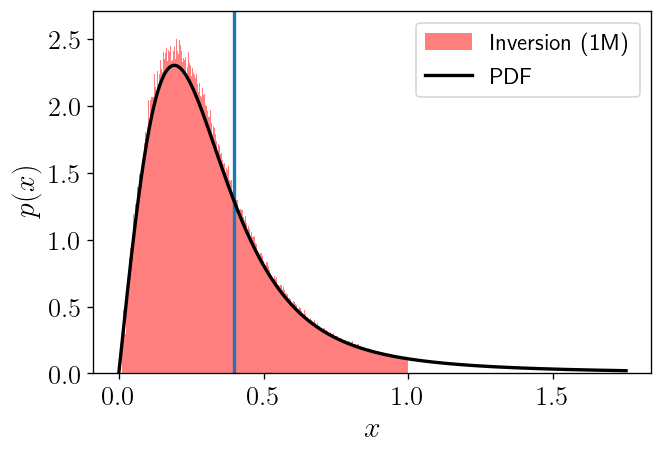

In [86]:
def psf_scale_factor_(E):
    """
    Scale factor for PSF for FRONT events

    Parameters
    ----------
    E : float
        energy (MeV)

    Returns
    -------
    float
        scale factor for PSF
    """
    c0 = 6.38e-2
    c1 = 1.26e-3
    beta = 0.8

    return np.sqrt((c0 * (E/100)**-beta)**2. + c1**2.)

fig = plt.figure(figsize=(6, 4), dpi= 120)
ax = fig.add_subplot(111)

_, bins, _ = ax.hist(psf_scale_factor_(E) * inv_rvs * 180 / np.pi, bins = np.logspace(-2,0,1000), density = True, alpha = 0.5, color = 'r', label = 'Inversion (1M)')
bin_centers = (bins[1:] + bins[:-1])/2
plt.axvline(np.mean(psf_scale_factor_(E) * inv_rvs * 180 / np.pi))

x = np.linspace(0,3,10000)
ax.plot(x * psf_scale_factor_(E) * 180 / np.pi, psf_(x, E, interpolation_functions) / (psf_scale_factor_(E) * 180 / np.pi), alpha = 1, color = 'k', label = 'PDF')

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend()
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

In [87]:
np.mean(inv_rvs *  psf_scale_factor_(E) * 180 / np.pi)

0.39791264231061274

In [59]:
(0.295392762810686+ 0.23526131082130958 ) / 2


0.2653270368159978

In [60]:
def king_(x,s,g):
    '''
    King profile (see Eq (3) 1309.5416)
    
    NOTE: This is a function of the angular deviation (radial distance).
    Therefore, the distribution is given by the expression in Eq (3) in 1309.5416
    multiplied by a factor of 2 \pi x, as we integrate over the azimuthal angles.

    Parameters
    ----------
    x : float
        angular deviation from the center
    s : float
        sigma parameter
    g : float
        gamma parameter

    Returns
    -------
    float
        King profile

    '''
    return (1 - 1 / g) * (1 + (x*x / 2 / s/s / g))**(-g) / s / s / 2 / np.pi

def king2_(x,s1,g1,s2,g2,f):
    '''
    Double King profile

    Parameters
    ----------
    x : float
        angular deviation from center
    s1 : float
        core sigma parameter
    g1 : float
        core gamma parameter
    s2 : float
        tail sigma parameter
    g2 : float
        tail gamma parameter
    f : float
        fraction of the tail king profile

    Returns
    -------
    float
        Double King profile
    '''
    return f * king_(x,s1,g1) + (1 - f) * king_(x,s2,g2)

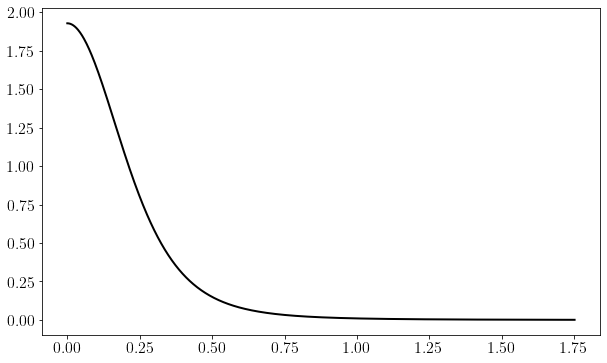

In [52]:
x = np.linspace(0, 3, 1000)
plt.plot((psf_scale_factor_(E) * 180 / np.pi) * x, psf_(x, E, interpolation_functions) / (psf_scale_factor_(E) * 180 / np.pi), alpha = 1, color = 'k', label = 'PDF')

# interpolate to invert the psf

